In [138]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

In [139]:
import numpy as np
from scipy.special import softmax

In [140]:
import pandas as pd
import re

In [12]:
UK_df = pd.read_csv('data/ElectricCarUK-comments.csv')
UK_df.head()

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,saved,score,stickied,subreddit_name,subreddit_id
0,jchannon,"This looks great, will check it out. Surprise...","<div class=""md""><p>This looks great, will chec...",1548355257,None,None,eev2r1k,None,t3_ajbhjw,t3_ajbhjw,/r/ElectricCarUK/comments/ajbhjw/ive_made_an_a...,None,2,None,ElectricCarUK,t5_o9449
1,[deleted],Super thrilled you’ve done this! 1 small thing...,"<div class=""md""><p>Super thrilled you’ve done ...",1548368952,None,None,eevop91,None,t3_ajbhjw,t3_ajbhjw,/r/ElectricCarUK/comments/ajbhjw/ive_made_an_a...,None,2,None,ElectricCarUK,t5_o9449
2,antpk,Love it but unfortunately I'm on Android.,"<div class=""md""><p>Love it but unfortunately I...",1548331143,None,None,eeu6fez,None,t3_ajbhjw,t3_ajbhjw,/r/ElectricCarUK/comments/ajbhjw/ive_made_an_a...,None,2,None,ElectricCarUK,t5_o9449
3,FillingUpTheDatabase,From 10th June 2021 this will be the pricing f...,"<div class=""md""><p>From 10th June 2021 this wi...",1622556382,None,1622557075,h070epp,TRUE,t3_npusqp,t3_npusqp,/r/ElectricCarUK/comments/npusqp/bp_pulse_pric...,None,2,None,ElectricCarUK,t5_o9449
4,happysleepygoat,I’m confused by this email. \n\nMy workplace h...,"<div class=""md""><p>I’m confused by this email....",1622559742,None,None,h077ld1,None,t3_npusqp,t3_npusqp,/r/ElectricCarUK/comments/npusqp/bp_pulse_pric...,None,1,None,ElectricCarUK,t5_o9449


In [72]:
evcharging_df = pd.read_csv('data/evcharging-comments.csv')
evcharging_df.head()

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,saved,score,stickied,subreddit_name,subreddit_id
0,JacksonDWalter,Something similar to this occurred at a loft m...,"<div class=""md""><p>Something similar to this o...",1698195708,None,None,k6bxtk8,None,t3_17fryug,t3_17fryug,/r/evcharging/comments/17fryug/mind_your_idle_...,None,41,None,evcharging,t5_vprim
1,nxtiak,What a fool. I've unplugged people that finish...,"<div class=""md""><p>What a fool. I&#39;ve unplu...",1698193918,None,1698194101,k6btdk7,None,t3_17fryug,t3_17fryug,/r/evcharging/comments/17fryug/mind_your_idle_...,None,94,None,evcharging,t5_vprim
2,Illcatchyoubeerbaron,My office has some free chargers for employees...,"<div class=""md""><p>My office has some free cha...",1698209135,None,None,k6crcgj,None,t3_17fryug,t3_17fryug,/r/evcharging/comments/17fryug/mind_your_idle_...,None,20,None,evcharging,t5_vprim
3,odinsen251a,New high score!,"<div class=""md""><p>New high score!</p>\n</div>",1698205954,None,None,k6cll3q,None,t3_17fryug,t3_17fryug,/r/evcharging/comments/17fryug/mind_your_idle_...,None,5,None,evcharging,t5_vprim
4,simplystriking,"I ain't unplugging shit, they wanna waste othe...","<div class=""md""><p>I ain&#39;t unplugging shit...",1698225184,None,None,k6dd0lv,None,t3_17fryug,t3_17fryug,/r/evcharging/comments/17fryug/mind_your_idle_...,None,5,None,evcharging,t5_vprim


In [80]:
RealTesla_df = pd.read_csv('data/RealTesla-comments.csv')



In [86]:
Bolt_df = pd.read_csv('data/BoltEV-comments.csv')


In [141]:
def drop_useless_columns(df):
    # Drop unnecessary columns
    df = df[['author','body','score']]
    # Rename some columns
    df.rename(columns={'body': 'text'}, inplace=True)
    return df

In [142]:
def drop_bot_comment(df): 
    # Get the list of bots comments
    bot_list = [
        'Decronym',
        'stabbot',
        'stabbot_crop',
        'DeepFryBot',
        'gifreversingbot',
        'vredditshare',
        'VredditDownloader',
        'morejpeg_auto',
        'gifendore',
        'r2tg_bot',
        'WololoBot',
        'tippr',
        'RemindMeBot',
        'profanitycounter',
        'Eminem_Bot'
    ]

    # Check number of posts is bot author
    print(f"Number of bot comments: {df[df['author'].isin(bot_list)].shape[0]}")
    df = df[~df['author'].isin(bot_list)]
    df = df.drop(columns=['author'])
    return df

In [143]:
def remove_multiple_spaces(text):
    # Count
    num_substitutions = len(re.findall(r'\s+', text)) - 1 # Minus 1 because we are replacing with 1 space
    # Remove
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text, num_substitutions
def remove_df_extra_spaces(df):
    df['text'], counts = zip(*df['text'].apply(remove_multiple_spaces))
    print(f"Number of removed extra spaces: {sum(counts)}")
    return df

In [144]:
def replace_abbr(text):    
    abbr_mapper = {
        # Reddit abbreviations & Slangs
        'Alt': 'Alternative Reddit account',
        'AMA': 'Ask me anything',
        'AMAA': 'Ask me almost anything',
        'Benned': 'Banned',
        'Brony': 'Male fan of My Little Pony',
        'Cakeday': 'Birthday',
        'Circlejerk': 'Elitist group',
        'DAE': 'Does anyone else',
        'Ent': 'Pot smoker',
        'ETA': 'Edited to add',
        'F7U12': 'FU',
        'Fap': 'Masturbate',
        '[FIXED]': 'Remix of an original post',
        'FTA': 'From the article',
        'FTFY': 'Fixed That For You',
        'GW': 'Gone wild',
        'Hivemind': 'Collective',
        'IAMA': 'I Am A',
        'IMO': 'In My Opinion',
        'IMHO': 'In my honest opinion',
        'IIRC': 'If i recall correctly',
        'ITT': 'In this thread',
        'Karma': 'Reddit score',
        'Karmawhore': 'Desperate for reddit points',
        'Meta-sub': 'Subreddits talking about Reddit',
        'Meta-subreddits': 'Subreddits talking about Reddit',
        'MIC': 'More in comments',
        'Mod': 'Moderator',
        'MRA': 'Mens rights activist',
        'Neckbeard': 'Dirty reddit user',
        'Ninjaedit': 'sneaky edit',
        'Novelty account': 'joke account',
        'NSFW': 'Not safe for work',
        'NSFL': 'Not safe for life',
        'OP': 'Original Poster',
        'Orangered': 'Unread messages',
        'Power user': 'User with high reddit score',
        'Pun thread': 'Chain of punny comments',
        'Reddiquette': 'Rules of reddit',
        'RES': 'Reddit enhancement suite',
        'RTFA': 'Read the fucking article',
        'Shadow-ban': 'Silent ban',
        'Shitpost': 'Trash post',
        'Sockpuppet': 'Alternate reddit account',
        'SJW': 'Social Justice Warrior',
        'SRD': 'Subreddit drama',
        'SRS': 'Shit reddit says',
        'Sub': 'Subreddit',
        'TIL': 'Today I learned',
        'TL;DR': 'Too Long Didnt read',
        'TLDR': 'Too Long Didnt read',
        'WIP': 'Work in progress',
        'X-post': 'Crosspost',
        'Xpost': 'Crosspost',
        'wh[o]+sh': 'Dont get the joke',
        
        # Replace model names with their full brand names as well, Electric car domain specific abbreviations & slangs
        
        
        # Other common internet abbr & slangs
        'LOL': 'Laugh out loud',
        'TTYL': 'Talk to you later',
        'ASAP': 'As soon as possible',
        'FYI': 'For your information',
        'JK': 'Just kidding',
        'IDC': 'I dont care',
        'FTW': 'For the win',
        'LMAO': 'Laughing my ass off',
        'LMFAO': 'Laughing my fucking ass off',
        'BFF': 'Best friend forever',
        'MFW': 'My face when',
        'TFW': 'That feeling when',
        'G2G': 'Got to go',
        'MSG': 'Message',
    }
    
    # Standardize all cases in mapper
    abbr_mapper =  {key.lower(): val for key, val in abbr_mapper.items()}

    # Regex to match every key
    # r'\b' -> Matches from start to finish
    # (?:) -> Capturing group
    # '|'.join(mapper) -> Loop and form pattern of all keys
    pattern = r'\b(?:' + r'|'.join(re.escape(abbr) for abbr in [k.lower() for k in abbr_mapper.keys()]) + r')\b'
    # Compile and replace
    pattern = re.compile(pattern, re.IGNORECASE)
    # Count
    num_substitutions = len(re.findall(pattern, text))
    replaced_text = pattern.sub(lambda match: abbr_mapper[match.group(0).lower()], text)

    return replaced_text, num_substitutions

def df_replace_abbr(df):
    # Apply to text field of df
    df['text'], counts = zip(*df['text'].apply(replace_abbr))
    print(f"Number of replaced abbreviations: {sum(counts)}")
    return df

In [145]:
# Function to count words in a sentence
def count_words(sentence):
    words = sentence.split()
    return len(words)

def select_comments(df, min, max):
    # Add a column with the number of words in each sentence
    df['Word Count'] = df['text'].apply(count_words)
    # Select rows with sentences containing 4 to 20 words
    selected_rows = df[(df['Word Count'] >= min) & (df['Word Count'] <= max)]
    selected_rows = selected_rows.drop(columns=['Word Count'])
    print("Number of selected rows:", len(selected_rows))
    return selected_rows

In [153]:
def preprocess(df, min, max):
    print("Number of rows in original dataset: ", len(df))
    df = drop_useless_columns(df)
    df = drop_bot_comment(df)
    df = remove_df_extra_spaces(df)
    df = df_replace_abbr(df)
    df = select_comments(df, min, max)
    return df

In [154]:
def all_preprocess(df, min, max):
    print("Number of rows in original dataset: ", len(df))
    #df = drop_useless_columns(df)
    #df = drop_bot_comment(df)
    df = remove_df_extra_spaces(df)
    df = df_replace_abbr(df)
    df = select_comments(df, min, max)
    return df

In [54]:
processed_UK_df = preprocess(UK_df, 5, 450)
processed_UK_df.head(10)

Number of rows in original dataset:  73
Number of bot comments: 0
Number of removed extra spaces: 4561
Number of replaced abbreviations: 0
Number of selected rows: 67


,text,score
0,"This looks great, will check it out. Surprised...",2
1,Super thrilled you’ve done this! 1 small thing...,2
2,Love it but unfortunately I'm on Android.,2
3,From 10th June 2021 this will be the pricing f...,2
4,I’m confused by this email. My workplace has “...,1
5,"I have to admit, I have 0 idea how much I spen...",1
6,This is what I’ve been waiting for. The sooner...,2
7,This one looks like it has 43kw AC but the one...,2
9,I’ve answered your questionnaire. Good luck wi...,2
12,Seems poorly planned not having chargers a vis...,2


In [148]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [149]:
def prediction(text):
#text = "Covid cases are increasing fast!"
#text = preprocess(text)
#encoded_input = tokenizer(processed_UK_df['text'].tolist(), max_length=514, padding=True, truncation=True, return_tensors="pt")
    #print(text)
    encoded_input = tokenizer(text, max_length=500, padding=True, truncation=True, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    label = config.id2label[ranking[0]]
    return scores, label


In [13]:
text = "Covid cases are increasing fast!"
scores, label = prediction(text)
print(scores)
print(label)

[0.7235768  0.2286789  0.04774429]
negative


In [60]:
scores_list, labels = zip(*processed_UK_df['text'].apply(prediction))


In [58]:
#encoded_input = tokenizer(processed_UK_df['text'].tolist(), max_length=500, padding=True, truncation=True, return_tensors="pt")
#print(text)
#encoded_input = tokenizer(text, max_length=500, padding=True, truncation=True, return_tensors="pt")
#output = model(**encoded_input)

In [150]:
def classification(df,name):
    print("start classification")
    scores_list, labels = zip(*df['text'].apply(prediction))
    s_list = np.array(scores_list)
    df["neg_score"] = s_list[:, 0]
    df["neu_score"] = s_list[:, 1]
    df["pos_score"] = s_list[:, 2]
    df["label"] = labels
    df.to_csv(f"classification/{name}.csv",index=False, encoding='utf-8')
    return df

In [64]:
processed_UK_df.head(10)

,text,score,neg_score,neu_score,pos_score,label
0,"This looks great, will check it out. Surprised...",2,0.008371,0.025596,0.966033,positive
1,Super thrilled you’ve done this! 1 small thing...,2,0.055226,0.147884,0.796890,positive
2,Love it but unfortunately I'm on Android.,2,0.356486,0.270438,0.373076,positive
3,From 10th June 2021 this will be the pricing f...,2,0.045968,0.898498,0.055533,neutral
4,I’m confused by this email. My workplace has “...,1,0.201317,0.765437,0.033245,neutral
5,"I have to admit, I have 0 idea how much I spen...",1,0.732036,0.231553,0.036411,negative
6,This is what I’ve been waiting for. The sooner...,2,0.005787,0.053832,0.940381,positive
7,This one looks like it has 43kw AC but the one...,2,0.498156,0.331384,0.170460,negative
9,I’ve answered your questionnaire. Good luck wi...,2,0.005441,0.090637,0.903922,positive
12,Seems poorly planned not having chargers a vis...,2,0.776949,0.208614,0.014437,negative


In [70]:
processed_UK_df.to_csv("classification/UK_comment.csv",index=False, encoding='utf-8')

In [78]:
processed_evcharging_df = preprocess(evcharging_df,5,500)
predict_evcharging = classification(processed_evcharging_df, "evcharging")
predict_evcharging.head(15)

Number of rows in original dataset:  1339
Number of bot comments: 0
Number of removed extra spaces: 48243


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/823002335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'body': 'text'}, inplace=True)


Number of replaced abbreviations: 63
Number of selected rows: 1225


,text,score,neg_score,neu_score,pos_score,label
0,Something similar to this occurred at a loft m...,41,0.687681,0.299403,0.012917,negative
1,What a fool. I've unplugged people that finish...,94,0.666745,0.299159,0.034096,negative
2,My office has some free chargers for employees...,20,0.374554,0.534225,0.091221,neutral
4,"I ain't unplugging shit, they wanna waste othe...",5,0.835935,0.153498,0.010567,negative
5,I 100% support this fee and wish it were even ...,3,0.141329,0.302278,0.556393,positive
6,Laugh out loud! They got charged what they des...,2,0.623661,0.293311,0.083028,negative
7,My apartment charges $10 an hour to idle… this...,2,0.915550,0.076569,0.007881,negative
8,"If I was in a particularly snarktastic mood, I...",2,0.706766,0.277994,0.015240,negative
9,Airport by me has charging stations with six h...,2,0.449910,0.483379,0.066711,neutral
10,"Pfft, looks like my trucks weekly gas bill. La...",2,0.460984,0.348875,0.190141,negative


In [84]:
processed_RealTesla_df = preprocess(RealTesla_df,5,500)
predict_RealTesla = classification(processed_RealTesla_df, "RealTesla")


Number of rows in original dataset:  10786
Number of bot comments: 0
Number of removed extra spaces: 216375


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/823002335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'body': 'text'}, inplace=True)


Number of replaced abbreviations: 673
Number of selected rows: 9320
start classification


In [85]:
# Get value counts for the 'label' column
value_counts = predict_RealTesla['label'].value_counts()

# Calculate the total number of values in the column
total_count = len(predict_RealTesla)

# Calculate the percentage and count for each unique value
percentage_counts = (value_counts / total_count) * 100
absolute_counts = value_counts

# Display the results
print("Percentage of each unique value:")
print(percentage_counts)
print("\nAbsolute count of each unique value:")
print(absolute_counts)

Percentage of each unique value:
negative    58.744635
neutral     31.030043
positive    10.225322
Name: label, dtype: float64

Absolute count of each unique value:
negative    5475
neutral     2892
positive     953
Name: label, dtype: int64


In [122]:
popular_comment_Tesla = predict_RealTesla[((predict_RealTesla['score'] >= 17)&(predict_RealTesla['label'] == "negative"))\
                                           |((predict_RealTesla['score'] >= 9)&(predict_RealTesla['label'] == "neutral"))\
                                            |((predict_RealTesla['score'] >= 3)&(predict_RealTesla['label'] == "positive"))]
print(popular_comment_Tesla.shape)
# Get value counts for the 'label' column
value_counts = popular_comment_Tesla['label'].value_counts()

# Calculate the total number of values in the column
total_count = len(popular_comment_Tesla)

# Calculate the percentage and count for each unique value
percentage_counts = (value_counts / total_count) * 100
absolute_counts = value_counts

# Display the results
print("Percentage of each unique value:")
print(percentage_counts)
print("\nAbsolute count of each unique value:")
print(absolute_counts)

(1289, 6)
Percentage of each unique value:
negative    43.444531
neutral     32.660978
positive    23.894492
Name: label, dtype: float64

Absolute count of each unique value:
negative    560
neutral     421
positive    308
Name: label, dtype: int64


In [128]:
popular_comment_Tesla[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
popular_comment_Tesla.to_csv("classification/popular_comment_Telsa.csv",index=False, encoding='utf-8')


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/3449500806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_comment_Tesla[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/3449500806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_comment_Tesla[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykern

In [87]:
processed_Bolt_df = preprocess(Bolt_df,5,500)
predict_Bolt = classification(processed_Bolt_df, "BoltEV")


Number of rows in original dataset:  4439
Number of bot comments: 0
Number of removed extra spaces: 111377


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/823002335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'body': 'text'}, inplace=True)


Number of replaced abbreviations: 237
Number of selected rows: 3879
start classification


In [88]:
# Get value counts for the 'label' column
value_counts = predict_Bolt['label'].value_counts()

# Calculate the total number of values in the column
total_count = len(predict_Bolt)

# Calculate the percentage and count for each unique value
percentage_counts = (value_counts / total_count) * 100
absolute_counts = value_counts

# Display the results
print("Percentage of each unique value:")
print(percentage_counts)
print("\nAbsolute count of each unique value:")
print(absolute_counts)

Percentage of each unique value:
neutral     39.572055
negative    37.535447
positive    22.892498
Name: label, dtype: float64

Absolute count of each unique value:
neutral     1535
negative    1456
positive     888
Name: label, dtype: int64


In [126]:
popular_comment_Bolt = predict_Bolt[((predict_Bolt['score'] >= 4)&(predict_Bolt['label'] == "negative"))\
                                           |((predict_Bolt['score'] >= 4)&(predict_Bolt['label'] == "neutral"))\
                                            |((predict_Bolt['score'] >= 3)&(predict_Bolt['label'] == "positive"))]
print(popular_comment_Bolt.shape)
# Get value counts for the 'label' column
value_counts = popular_comment_Bolt['label'].value_counts()

# Calculate the total number of values in the column
total_count = len(popular_comment_Bolt)

# Calculate the percentage and count for each unique value
percentage_counts = (value_counts / total_count) * 100
absolute_counts = value_counts

# Display the results
print("Percentage of each unique value:")
print(percentage_counts)
print("\nAbsolute count of each unique value:")
print(absolute_counts)

(1196, 6)
Percentage of each unique value:
neutral     35.284281
negative    33.612040
positive    31.103679
Name: label, dtype: float64

Absolute count of each unique value:
neutral     422
negative    402
positive    372
Name: label, dtype: int64


In [165]:
combined_df = pd.read_csv("majorityVoting.csv")
value_counts = combined_df['label'].value_counts()

# Calculate the total number of values in the column
total_count = len(combined_df)

# Calculate the percentage and count for each unique value
percentage_counts = (value_counts / total_count) * 100
absolute_counts = value_counts

# Display the results
print("Percentage of each unique value:")
print(percentage_counts)
print("\nAbsolute count of each unique value:")
print(absolute_counts)

Percentage of each unique value:
negative    34.332689
neutral     34.042553
positive    31.624758
Name: label, dtype: float64

Absolute count of each unique value:
negative    355
neutral     352
positive    327
Name: label, dtype: int64


In [129]:
popular_comment_Bolt[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
popular_comment_Bolt.to_csv("classification/popular_comment_Bolt.csv",index=False, encoding='utf-8')

/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/1452255117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_comment_Bolt[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_36576/1452255117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_comment_Bolt[["annotator 1","irony 1","remove 1","annotator 2","irony 2","remove 2"]] = ""
/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel

### Datasets to be labelled
2 datasets(subtopics): comments for BoltEV and comments for RealTesla. Existing columns: text, score(number of up-votes minus number of down-votes), softmax scores for all three lables, predicted label.

### Annotation instruction
2 annotators are needed, each of them need to do the following:
1. classify the comment as positive(1), neutral(0) or negative(-1) under the column annotater 1(2)
2. classify the comment as ironic(1) or unironic(0) under the column irony 1(2)
3. if you feel the comment lacks context to the extent that it is difficult to label, put 1 under the column remove 1(2)
4. if you feel the comment is not relevant to the subtopic, put 2 under the column remove 1(2)

Caveat: 
* Even you put 1 or 2 under column remove, still fill in the values for anotator and irony columns to the best of your knowledge. 
* Predicion results from the pre-trained model are available in the csv file. Try not to refer to them too much when doing the labelling. We use the annotators inputs as ground truths.
* We hope to have 1000 entries for each dataset. Currently each dataset has around 1.2k entries. That means we can accept around 200 entries to be removed for each dataset.  

### Model used for classification
A RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest The checkpoint is found on HuggingFace. No guarantee it will work well on our own dataset but it is the most relevant I can find. No training/finetuning is performed because we do not have labelled data at this time and very likely will not have the time to label extra data besides the 2 test datasets in the future.

### Innovation
Considering ensemble classification or sarcasm detection. For both the most feasible approach will still be using checkpoints on hugging face. The irony columns are labelled so we can experiment on sarcasm detection, if the results are too bad, may just switch to ensemble classification or other methods that do not require extra labelling. 

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [14]:
annotateddf = pd.read_csv('popular_comment_Bolt_annotate_Merged.csv')

In [18]:
Bolt_predicted = pd.read_csv('classification/popular_comment_Bolt.csv')

In [19]:
annotateddf['annotator_combined'] = np.where(annotateddf['annotator 1'] == annotateddf['annotator 2'], annotateddf['annotator 1'], np.nan)
valid_count = annotateddf['annotator_combined'].count()
print("valid count: ", valid_count)
annotateddf.dropna(subset=['annotator_combined'], inplace=True)


valid count:  1068


In [20]:
annotateddf['annotator_combined'] = annotateddf['annotator_combined'].astype(str)
sentiment_mapping = {'-1.0': 'negative', '0.0': 'neutral', '1.0': 'positive'}

annotateddf['annotator_combined'] = annotateddf['annotator_combined'].replace(sentiment_mapping)

In [30]:
remove_count_1 = annotateddf['remove 1'].count()
print("remove 1:", remove_count_1)
remove_count_2 = annotateddf['remove 2'].count()
print("remove 2:", remove_count_1)

remove 1: 150
remove 2: 150


In [31]:
count_non_na = annotateddf[['remove 1', 'remove 2']].notna().all(axis=1).sum()
print("common remove: ", count_non_na)

common remove:  34


In [38]:
annotateddf = annotateddf[annotateddf['remove 1'].isna() | annotateddf['remove 2'].isna()]
print(len(annotateddf))

1034


In [39]:
annotation_df = annotateddf[["text","annotator_combined"]]

In [40]:
merged_df = pd.merge(Bolt_predicted, annotation_df, on='text', how='inner')
merged_df.head()

,text,score,neg_score,neu_score,pos_score,label,annotator 1,irony 1,remove 1,annotator 2,irony 2,remove 2,annotator_combined
0,An Ultium based Bolt with NACS and faster char...,219,0.004940,0.088701,0.906359,positive,NaN,NaN,NaN,NaN,NaN,NaN,neutral
1,They had to have something smaller than the Eq...,141,0.378837,0.540830,0.080333,neutral,NaN,NaN,NaN,NaN,NaN,NaN,negative
2,Yes! I just came back to post this very same t...,55,0.003039,0.012690,0.984271,positive,NaN,NaN,NaN,NaN,NaN,NaN,positive
3,Yes!!! So excited! Was thinking I was going to...,52,0.017278,0.055458,0.927264,positive,NaN,NaN,NaN,NaN,NaN,NaN,positive
4,Interesting that they dropped the EV/EUV namep...,21,0.032266,0.881413,0.086321,neutral,NaN,NaN,NaN,NaN,NaN,NaN,neutral


In [41]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['label'])
precision = precision_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8191489361702128
Precision: 0.8217577552345009
Recall: 0.8191489361702128
F1 Score: 0.8198113471835082


In [42]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['label'])
precision = precision_score(merged_df['annotator_combined'], merged_df['label'], average='micro')
recall = recall_score(merged_df['annotator_combined'], merged_df['label'], average='micro')
f1 = f1_score(merged_df['annotator_combined'], merged_df['label'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8191489361702128
Precision: 0.8191489361702128
Recall: 0.8191489361702128
F1 Score: 0.8191489361702128


In [44]:
from transformers import pipeline
classifier = pipeline('zero-shot-classification', model='roberta-large-mnli')

2024-04-09 22:59:13.767067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
config.json: 100%|██████████| 688/688 [00:00<00:00, 45.3kB/s]
model.safetensors: 100%|██████████| 1.43G/1.43G [03:11<00:00, 7.44MB/s]
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.wei

In [77]:
text_list = merged_df['text'].tolist()


In [80]:
len(text_list)

1034

In [84]:
def mnli_predictin(text):
    candidate_labels = ['positive', 'neutral', 'negative']
    result = classifier(text, candidate_labels)
    scores_list = result["scores"]
    labels_list = result["labels"]
    chosen_labels = labels_list[0]
    return scores_list, labels_list, chosen_labels

In [ ]:
candidate_labels = ['positive', 'neutral', 'negative']
result = classifier(text_list, candidate_labels)

In [66]:
result

[{'sequence': 'today is a bad day',
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9906196594238281, 0.007247406058013439, 0.0021329601295292377]}]

In [75]:
scores_list = [d['scores'] for d in result if 'scores' in d]
labels_list = [d['labels'] for d in result if 'labels' in d]
chosen_labels = list(zip(*labels_list))[0]

In [76]:
labels_list

['negative', 'positive']

In [85]:
scores_list, labels_list, labels = zip(*merged_df['text'].apply(mnli_predictin))

In [86]:
merged_df["mnli_label"] = labels

In [137]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['mnli_label'])
precision = precision_score(merged_df['annotator_combined'], merged_df['mnli_label'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['mnli_label'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['mnli_label'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6537717601547389
Precision: 0.6937598452290512
Recall: 0.6537717601547389
F1 Score: 0.6537717601547389


In [88]:
vaders = pd.read_csv('VadersTextBlobCombinedData.csv')


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_21964/3355802776.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  vaders = pd.read_csv('VadersTextBlobCombinedData.csv')


In [90]:
vaders = vaders[["text","vader_sentiment"]]
combined_df = pd.merge(vaders, merged_df, on='text', how='inner')


In [91]:
vote_counts = combined_df[["label","mnli_label","vader_sentiment"]].apply(pd.Series.value_counts, axis=1)

In [92]:
consensus_predictions = vote_counts.idxmax(axis=1)
combined_df['consensus_prediction'] = consensus_predictions

### majority voting for roberta, mnli,and vader

In [93]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['consensus_prediction'])
precision = precision_score(combined_df['annotator_combined'], combined_df['consensus_prediction'], average='weighted')
recall = recall_score(combined_df['annotator_combined'], combined_df['consensus_prediction'], average='weighted')
f1 = f1_score(combined_df['annotator_combined'], combined_df['consensus_prediction'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7350096711798839
Precision: 0.7565219647149439
Recall: 0.7350096711798839
F1 Score: 0.7197461219568052


In [98]:

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    top_k = None
)

In [108]:
distilled_student_sentiment_classifier ("I love this movie and i would watch it again and again!")
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}


In [109]:
def distilled_prediction(text):
    #print(text)
    result = distilled_student_sentiment_classifier(text,**tokenizer_kwargs)
    label = [item['label'] for item in result[0]][0]
    scores = [item['score'] for item in result[0]]
    return scores, label

In [110]:
distilled_scores, distilled_labels = zip(*combined_df['text'].apply(distilled_prediction))

In [111]:
combined_df["distilled_label"] = distilled_labels

In [112]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['distilled_label'])
precision = precision_score(combined_df['annotator_combined'], combined_df['distilled_label'], average='weighted')
recall = recall_score(combined_df['annotator_combined'], combined_df['distilled_label'], average='weighted')
f1 = f1_score(combined_df['annotator_combined'], combined_df['distilled_label'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5135396518375241
Precision: 0.5053416348267816
Recall: 0.5135396518375241
F1 Score: 0.4538706506308806


In [113]:
vote_counts = combined_df[["mnli_label","vader_sentiment","distilled_label"]].apply(pd.Series.value_counts, axis=1)
new_consensus_predictions = vote_counts.idxmax(axis=1)
combined_df['new_consensus_predictions'] = new_consensus_predictions

In [119]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['new_consensus_predictions'])
precision = precision_score(combined_df['annotator_combined'], combined_df['new_consensus_predictions'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['new_consensus_predictions'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['new_consensus_predictions'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6005802707930368
Precision: 0.6005802707930368
Recall: 0.6005802707930368
F1 Score: 0.6005802707930368


In [120]:
vote_counts = combined_df[["label","mnli_label","vader_sentiment","distilled_label"]].apply(pd.Series.value_counts, axis=1)
consensus_predictions4 = vote_counts.idxmax(axis=1)
combined_df['consensus_predictions4'] = consensus_predictions4

In [121]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['consensus_predictions4'])
precision = precision_score(combined_df['annotator_combined'], combined_df['consensus_predictions4'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['consensus_predictions4'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['consensus_predictions4'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6876208897485493
Precision: 0.6876208897485493
Recall: 0.6876208897485493
F1 Score: 0.6876208897485493


In [123]:
combined_df.to_csv("majorityVoting.csv",index = False)

In [124]:
bert_df = pd.read_csv("sentiment_pred_bert_pretrain_and_annotator.csv")

In [126]:
bert_df = bert_df[["text",'sentiment_pred_bert']]
bert_df.head()


,text,sentiment_pred_bert
0,An Ultium based Bolt with NACS and faster char...,positive
1,They had to have something smaller than the Eq...,neutral
2,Yes! I just came back to post this very same t...,positive
3,Yes!!! So excited! Was thinking I was going to...,positive
4,Interesting that they dropped the EV/EUV namep...,positive


In [127]:
combined_df = pd.merge(combined_df, bert_df, on='text', how='inner')


In [128]:
vote_counts = combined_df[["label","mnli_label","vader_sentiment","distilled_label","sentiment_pred_bert"]].apply(pd.Series.value_counts, axis=1)
consensus_predictions5 = vote_counts.idxmax(axis=1)
combined_df['consensus_predictions5'] = consensus_predictions5

In [133]:
vote_counts = combined_df[["vader_sentiment","mnli_label","sentiment_pred_bert"]].apply(pd.Series.value_counts, axis=1)
consensus_predictions3 = vote_counts.idxmax(axis=1)
combined_df['consensus_predictions3'] = consensus_predictions3

In [129]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['consensus_predictions5'])
precision = precision_score(combined_df['annotator_combined'], combined_df['consensus_predictions5'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['consensus_predictions5'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['consensus_predictions5'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7282398452611218
Precision: 0.7282398452611218
Recall: 0.7282398452611218
F1 Score: 0.728239845261122


In [134]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['consensus_predictions3'])
precision = precision_score(combined_df['annotator_combined'], combined_df['consensus_predictions3'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['consensus_predictions3'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['consensus_predictions3'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6760154738878144
Precision: 0.6760154738878144
Recall: 0.6760154738878144
F1 Score: 0.6760154738878144


In [135]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['sentiment_pred_bert'])
precision = precision_score(combined_df['annotator_combined'], combined_df['sentiment_pred_bert'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['sentiment_pred_bert'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['sentiment_pred_bert'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6334622823984526
Precision: 0.6334622823984526
Recall: 0.6334622823984526
F1 Score: 0.6334622823984526


In [136]:
accuracy = accuracy_score(combined_df['annotator_combined'], combined_df['vader_sentiment'])
precision = precision_score(combined_df['annotator_combined'], combined_df['vader_sentiment'], average='micro')
recall = recall_score(combined_df['annotator_combined'], combined_df['vader_sentiment'], average='micro')
f1 = f1_score(combined_df['annotator_combined'], combined_df['vader_sentiment'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5560928433268859
Precision: 0.5560928433268859
Recall: 0.5560928433268859
F1 Score: 0.5560928433268859


In [151]:
all_df = pd.read_csv("data/cleaned_combined_data.csv")

In [155]:
processed_all_df = all_preprocess(all_df,5,500)
predict_all = classification(processed_all_df, "roberta_cleaned_combined_data")
predict_all.head(15)

Number of rows in original dataset:  49359
Number of removed extra spaces: 1075974
Number of replaced abbreviations: 0
Number of selected rows: 41968
start classification


,author,text,created_utc,edited,id,num_comments,permalink,upvote,subreddit_name,upvote_ratio,url,type,post_id,text_spellcheck,neg_score,neu_score,pos_score,label
0,[deleted],My reward for finally finishing my bachelor’s ...,2022-03-29T02:55:49Z,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN,My reward for finally finishing my bachelor’s ...,0.002883,0.011915,0.985202,positive
2,labdweller,Rabbit stowage area on the i3,2023-03-14T18:13:18Z,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN,Rabbit stowage area on the i3,0.042259,0.883902,0.073839,neutral
3,toteratte21,Picked her up straight from the source in Munich,2023-05-25T16:42:53Z,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN,Picked her up straight from the source in Munich,0.013853,0.874376,0.111771,neutral
4,azscram9,Picked up this little gem over the weekend,2023-05-22T01:33:12Z,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN,Picked up this little gem over the weekend,0.003443,0.172926,0.823631,positive
7,ba_nanas,It’s here! Galvanic Gold i3s. I absolutely lov...,2021-03-04T00:53:47Z,NaN,lwyior,22.0,/r/BMWi3/comments/lwyior/its_here_galvanic_gol...,167,BMWi3,0.99,https://i.redd.it/0mhjgabhfuk61.jpg,post,NaN,It’s here! Galvanic Gold i3s. I absolutely lov...,0.002945,0.007544,0.989511,positive
8,PNW-i3S-AC-Schnitzer,“Das Blau Edition” BMW i3S AC Schnitzer,2021-11-22T08:09:52Z,NaN,qz86xw,22.0,/r/BMWi3/comments/qz86xw/das_blau_edition_bmw_...,154,BMWi3,0.99,https://i.redd.it/tmwwn3d0h1181.jpg,post,NaN,“Das Blau Edition” BMW i3S AC Schnitzer,0.007237,0.839984,0.152779,neutral
9,QuieroTamales,Found some old i3 tires at an antique shop.,2021-06-28T05:38:13Z,NaN,o968u1,11.0,/r/BMWi3/comments/o968u1/found_some_old_i3_tir...,149,BMWi3,1.00,https://i.redd.it/j7c53qhunv771.png,post,NaN,Found some old i3 tires at an antique shop.,0.024056,0.772683,0.203261,neutral
10,cornnibblitz,"Longtime admirer of the i3 from afar, I finall...",2023-03-04T05:35:44Z,NaN,11hfps3,39.0,/r/BMWi3/comments/11hfps3/longtime_admirer_of_...,147,BMWi3,0.99,https://i.redd.it/d7fy5gxvella1.jpg,post,NaN,"Longtime admirer of the i3 from afar, I finall...",0.003648,0.026707,0.969645,positive
11,earaache,I got a few of these for the folks in Portland...,2023-05-19T08:35:11Z,NaN,13lfxz5,25.0,/r/BMWi3/comments/13lfxz5/i_got_a_few_of_these...,143,BMWi3,0.99,https://i.redd.it/j59diek06q0b1.jpg,post,NaN,I got a few of these for the folks in Portland...,0.010690,0.763509,0.225802,neutral
13,ryanoscerous,Best Car I’ve Ever Owned,2022-06-05T20:31:35Z,NaN,v5cedu,51.0,/r/BMWi3/comments/v5cedu/best_car_ive_ever_owned/,142,BMWi3,1.00,https://i.redd.it/0mr03ox2rs391.jpg,post,NaN,Best Car I’ve Ever Owned,0.005339,0.026101,0.968560,positive


In [9]:
vader = pd.read_csv("VadersTextBlobCombinedData.csv")
vader.head()

/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_40157/2882851337.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  vader = pd.read_csv("VadersTextBlobCombinedData.csv")


,row_id,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment,vader_subjectivity,tbpolarityscore,textblob_sentiment,tbsubjectivityscore,...,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id
0,1,0.063,0.673,0.265,0.8275,positive,subjective,0.28125,positive,0.833333,...,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN
1,2,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN
2,3,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN
3,4,0.000,0.808,0.192,0.2263,positive,subjective,0.20000,positive,0.400000,...,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN
4,5,0.000,1.000,0.000,0.0000,neutral,objective,-0.18750,negative,0.500000,...,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN


In [13]:
predict_all = pd.read_csv("classification/roberta_cleaned_combined_data.csv")

/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_40157/2164282516.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  predict_all = pd.read_csv("classification/roberta_cleaned_combined_data.csv")


In [16]:
merged_all = pd.merge(vader, predict_all, how='inner')


In [167]:
predict_all.columns

Index(['author', 'text', 'created_utc', 'edited', 'id', 'num_comments',
       'permalink', 'upvote', 'subreddit_name', 'upvote_ratio', 'url', 'type',
       'post_id', 'text_spellcheck', 'neg_score', 'neu_score', 'pos_score',
       'label'],
      dtype='object')

In [169]:
vader.columns

Index(['row_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'vader_sentiment', 'vader_subjectivity', 'tbpolarityscore',
       'textblob_sentiment', 'tbsubjectivityscore', 'textblob_subjectivity',
       'author', 'text', 'created_utc', 'edited', 'id', 'num_comments',
       'permalink', 'score', 'subreddit_name', 'upvote_ratio', 'url', 'type',
       'post_id'],
      dtype='object')

In [17]:
merged_all.columns

Index(['row_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'vader_sentiment', 'vader_subjectivity', 'tbpolarityscore',
       'textblob_sentiment', 'tbsubjectivityscore', 'textblob_subjectivity',
       'author', 'text', 'created_utc', 'edited', 'id', 'num_comments',
       'permalink', 'score', 'subreddit_name', 'upvote_ratio', 'url', 'type',
       'post_id', 'upvote', 'text_spellcheck', 'neg_score', 'neu_score',
       'pos_score', 'label'],
      dtype='object')

In [162]:
merged_all = merged_all[['row_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'vader_sentiment', 'vader_subjectivity', 'tbpolarityscore',
       'textblob_sentiment', 'tbsubjectivityscore', 'textblob_subjectivity',
       'author', 'text', 'created_utc', 'edited', 'id', 'num_comments',
       'permalink', 'score', 'subreddit_name', 'upvote_ratio', 'url', 'type',
       'post_id', 'upvote', 'text_spellcheck', 'neg_score', 'neu_score',
       'pos_score', 'label']]

In [166]:
merged_all.head()

,row_id,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment,vader_subjectivity,tbpolarityscore,textblob_sentiment,tbsubjectivityscore,...,url_x,type_x,post_id_x,author_y,upvote,text_spellcheck,neg_score,neu_score,pos_score,label
0,1,0.063,0.673,0.265,0.8275,positive,subjective,0.28125,positive,0.833333,...,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN,[deleted],223,My reward for finally finishing my bachelor’s ...,0.002883,0.011915,0.985202,positive
1,3,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,https://i.redd.it/yewt745fjona1.jpg,post,NaN,labdweller,192,Rabbit stowage area on the i3,0.042259,0.883902,0.073839,neutral
2,4,0.000,0.808,0.192,0.2263,positive,subjective,0.20000,positive,0.400000,...,https://i.imgur.com/7jTu2dR.jpg,post,NaN,toteratte21,176,Picked her up straight from the source in Munich,0.013853,0.874376,0.111771,neutral
3,5,0.000,1.000,0.000,0.0000,neutral,objective,-0.18750,negative,0.500000,...,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN,azscram9,173,Picked up this little gem over the weekend,0.003443,0.172926,0.823631,positive
4,8,0.000,0.583,0.417,0.8620,positive,subjective,0.55000,positive,0.750000,...,https://i.redd.it/0mhjgabhfuk61.jpg,post,NaN,ba_nanas,167,It’s here! Galvanic Gold i3s. I absolutely lov...,0.002945,0.007544,0.989511,positive


In [18]:
merged_all.to_csv("classification/merged_all_new.csv",index = False)

In [5]:
merged_all = pd.read_csv("classification/merged_all.csv")
count_different_values = (merged_all['author_x'] != merged_all['author_y']).sum()
rows_with_different_values = merged_all[merged_all['author_x'] != merged_all['author_y']]
print("Number of rows where 'column1' and 'column2' values are different:", count_different_values)
print("Rows where 'column1' and 'column2' values are different:")


Number of rows where 'column1' and 'column2' values are different: 42
Rows where 'column1' and 'column2' values are different:


/var/folders/zd/n573jzn975s_mpdy3pm9tt1h0000gn/T/ipykernel_40157/2320431550.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_all = pd.read_csv("classification/merged_all.csv")


In [7]:
rows_with_different_values[["author_x","author_y","text"]].head()

,author_x,author_y,text
176,wewewawa,TiltedWit,If You Bought A Tesla One Year Ago It Has Lost...
177,TiltedWit,wewewawa,If You Bought A Tesla One Year Ago It Has Lost...
318,manual_tranny,gman1023,Disapproval of Elon Musk is top reason Tesla o...
319,gman1023,manual_tranny,Disapproval of Elon Musk is top reason Tesla o...
704,mananuku,Local_Yoghurt9320,Admin fees are worse than ticketek


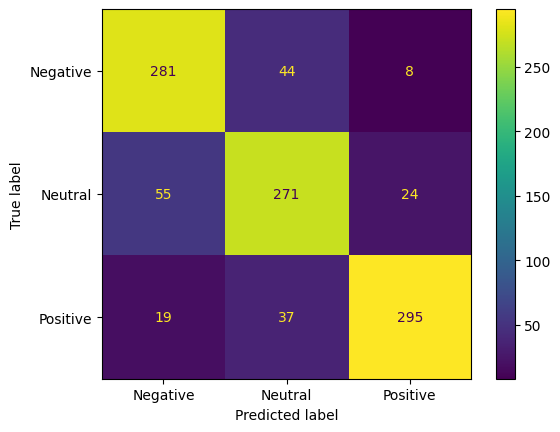

              precision    recall  f1-score   support

    negative       0.79      0.84      0.82       333
     neutral       0.77      0.77      0.77       350
    positive       0.90      0.84      0.87       351

    accuracy                           0.82      1034
   macro avg       0.82      0.82      0.82      1034
weighted avg       0.82      0.82      0.82      1034



<Figure size 640x480 with 0 Axes>

In [22]:
df = pd.read_csv("majorityVoting.csv")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(df['annotator_combined'], df['label'])

cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cmd.plot()
plt.show()

plt.savefig('confusion_matrix_roberta.png')
report = classification_report(df['annotator_combined'], df['label'], target_names=["negative", "neutral", "positive"])
print(report)

In [23]:
df.columns

Index(['text', 'vader_sentiment', 'score', 'neg_score', 'neu_score',
       'pos_score', 'label', 'annotator 1', 'irony 1', 'remove 1',
       'annotator 2', 'irony 2', 'remove 2', 'annotator_combined',
       'mnli_label', 'consensus_prediction', 'distilled_label',
       'new_consensus_predictions', 'consensus_predictions4'],
      dtype='object')

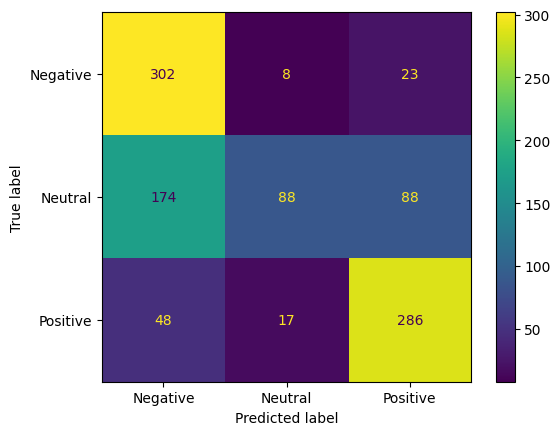

              precision    recall  f1-score   support

    negative       0.58      0.91      0.70       333
     neutral       0.78      0.25      0.38       350
    positive       0.72      0.81      0.76       351

    accuracy                           0.65      1034
   macro avg       0.69      0.66      0.62      1034
weighted avg       0.69      0.65      0.62      1034



<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(df['annotator_combined'], df['mnli_label'])

cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cmd.plot()
plt.show()

plt.savefig('confusion_matrix_mnli.png')
report = classification_report(df['annotator_combined'], df['mnli_label'], target_names=["negative", "neutral", "positive"])
print(report)

Random Accuracy: 0.32011605415860733


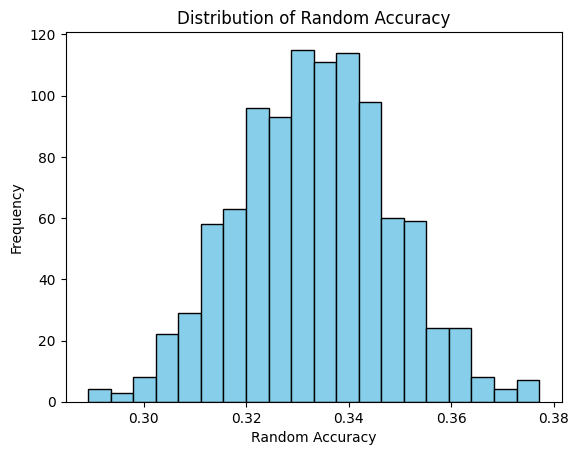

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("majorityVoting.csv")

# Function to convert text labels to numerical labels
def text_to_numeric(labels, label_mapping):
    return np.array([label_mapping[label] for label in labels])

# Generate random predictions (softmax scores) for 3 sentiments (positive, neutral, negative)
def generate_random_predictions(num_samples):
    random_predictions = np.random.rand(num_samples, 3)
    random_predictions /= np.sum(random_predictions, axis=1, keepdims=True)
    return random_predictions

# Evaluate accuracy of random predictions
def evaluate_random_accuracy(random_predictions, true_labels):
    predicted_labels = np.argmax(random_predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Example dataset with text-format true labels
true_labels_text = df['label'].to_list()
num_samples = len(true_labels_text)

# Mapping of text labels to numerical labels
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

# Convert text labels to numerical labels
true_labels_numeric = text_to_numeric(true_labels_text, label_mapping)

# Generate random predictions
random_predictions = generate_random_predictions(num_samples)

# Evaluate random accuracy
random_accuracy = evaluate_random_accuracy(random_predictions, true_labels_numeric)
print("Random Accuracy:", random_accuracy)

# Plot histogram of random accuracy distribution
num_iterations = 1000
random_accuracies = []
for _ in range(num_iterations):
    random_predictions = generate_random_predictions(num_samples)
    random_accuracy = evaluate_random_accuracy(random_predictions, true_labels_numeric)
    random_accuracies.append(random_accuracy)

plt.hist(random_accuracies, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Random Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Random Accuracy')
plt.show()

Random Accuracy: 0.33365570599613154


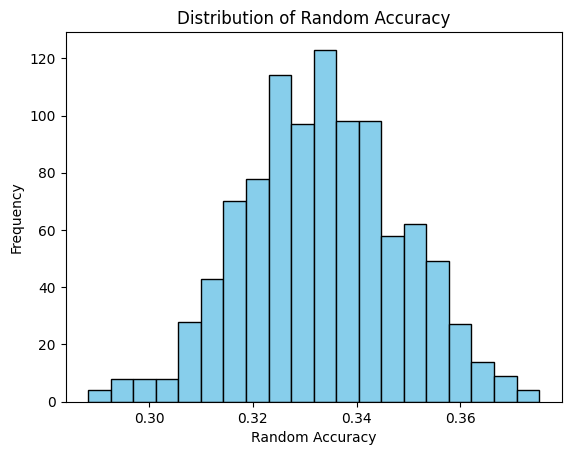

In [6]:
true_labels_text = df['mnli_label'].to_list()
num_samples = len(true_labels_text)

# Mapping of text labels to numerical labels
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

# Convert text labels to numerical labels
true_labels_numeric = text_to_numeric(true_labels_text, label_mapping)

# Generate random predictions
random_predictions = generate_random_predictions(num_samples)

# Evaluate random accuracy
random_accuracy = evaluate_random_accuracy(random_predictions, true_labels_numeric)
print("Random Accuracy:", random_accuracy)

# Plot histogram of random accuracy distribution
num_iterations = 1000
random_accuracies = []
for _ in range(num_iterations):
    random_predictions = generate_random_predictions(num_samples)
    random_accuracy = evaluate_random_accuracy(random_predictions, true_labels_numeric)
    random_accuracies.append(random_accuracy)

plt.hist(random_accuracies, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Random Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Random Accuracy')
plt.show()

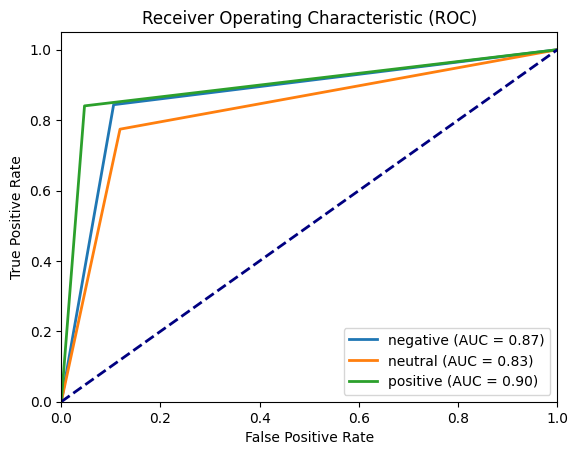

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

labels = df['annotator_combined']
classes = ['negative', 'neutral', 'positive']
y_true = label_binarize(labels, classes=classes)

# Assuming 'positive' class is considered as the positive class
# Convert sentiment scores to binary predictions
predicted_scores = df['label']
y_score = label_binarize(predicted_scores, classes=classes)
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='%s (AUC = %0.2f)' % (class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

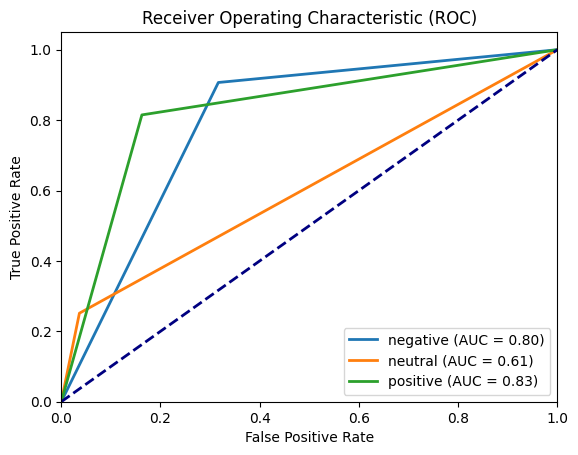

In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

labels = df['annotator_combined']
classes = ['negative', 'neutral', 'positive']
y_true = label_binarize(labels, classes=classes)

# Assuming 'positive' class is considered as the positive class
# Convert sentiment scores to binary predictions
predicted_scores = df['mnli_label']
y_score = label_binarize(predicted_scores, classes=classes)
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='%s (AUC = %0.2f)' % (class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()